In [2]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [3]:
data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_tech_nonscaled.parquet')
datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_nonscaled.parquet')

# prc_filter = 0.125

# data = data[data['prc_option'] > prc_filter]
# datat = datat[datat['prc_option'] > prc_filter]


impl_volatility = 'impl_volatility_h_1_step'

test_data = datat[datat['date'] >= '2021-01-01']
total_train = data[data['date'] < '2021-01-01']

# data = data_sso[data_sso['prc_option'] > prc_filter]
# datat = datat_sso[datat_sso['prc_option'] > prc_filter]

basic = ['moneyness', 'T']
option_specific = ['cp_flag', 'spread_option', 'volume', 'prc_option', 'previous_iv']
macro_features = ['2Y_bond','FF_rate', 'gold_price','reces_indi', 'CLOSE_vix', 'hi-lo_vix']
stock_specific = ['BID', 'ASK', 'daily_return_indicator_stock', 'hi-lo_stock', 'PRC', "vol_stock", 'RET', 'spread_stock']

tickers = ['ticker_AAPL', 'ticker_AMZN', 'ticker_META', 'ticker_MSFT','ticker_NVDA', 'ticker_TSLA'  ]


totalList = ['moneyness', 'T'] + macro_features + option_specific + stock_specific + tickers

Retraining final RandomForest model on combined 2019 and 2020 data...


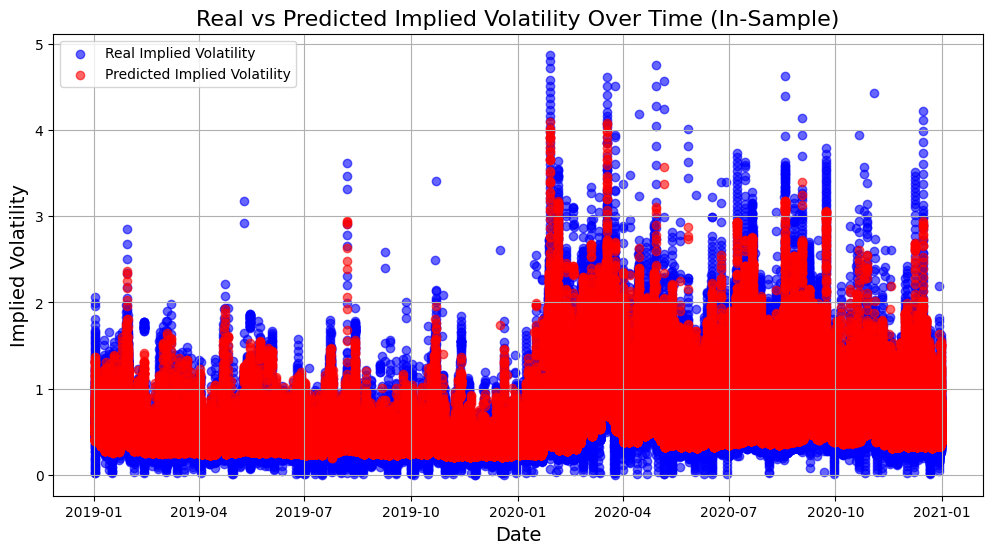

In-sample RMSE: 0.1242
In-sample R²: 0.9156


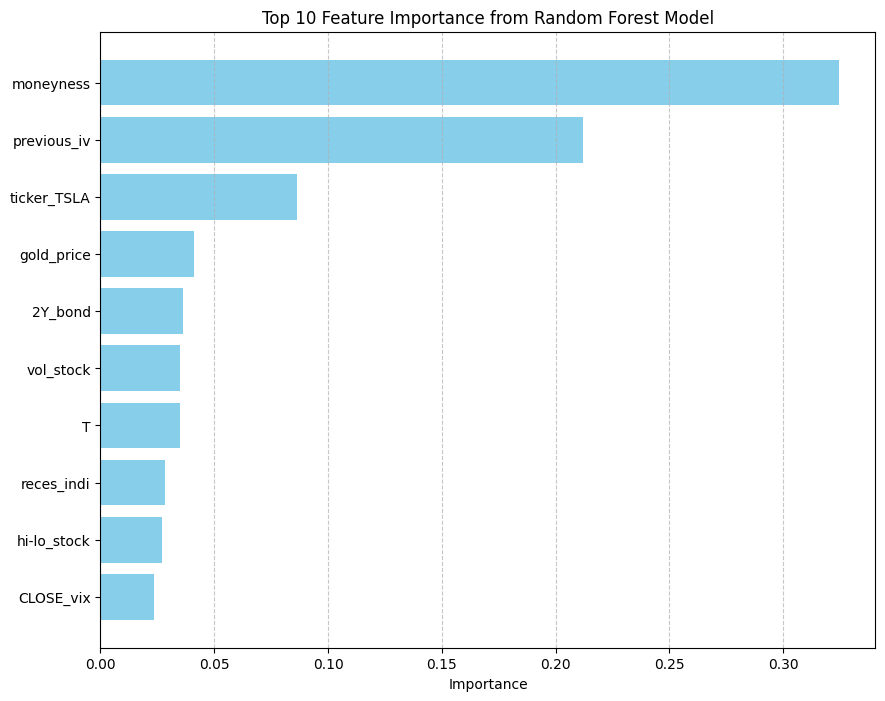

Final model and selected features have been saved.


In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

def retrain_final_model_rf(IV, data, selected_features, n_estimators, max_depth, max_features, min_samples_leaf, min_samples_split, random_state=42, verbose=0):
    """
    Retrain the final RandomForest model on combined 2019 and 2020 data with specified parameters
    and plot feature importance.
    """
    if verbose >= 1:
        print("Retraining final RandomForest model on combined 2019 and 2020 data...")

    # Combine training and validation data (2019 and 2020)
    combined_data = data[data['date'].dt.year <= 2020]
    combined_x = combined_data[selected_features]
    combined_y = combined_data[IV]

    # Train RandomForest with the specified parameters
    final_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        # min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        random_state=random_state
    )
    final_model.fit(combined_x, combined_y)

    # In-sample predictions and score calculation
    y_pred_in_sample = final_model.predict(combined_x)
    in_sample_rmse = np.sqrt(mean_squared_error(combined_y, y_pred_in_sample))
    in_sample_r2 = r2_score(combined_y, y_pred_in_sample)

    plot_real_vs_predicted(combined_data, combined_y, y_pred_in_sample, 'In-Sample')

    if verbose >= 1:
        print(f"In-sample RMSE: {in_sample_rmse:.4f}")
        print(f"In-sample R²: {in_sample_r2:.4f}")

    # Extract feature importances
    importance = final_model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    # Normalize importance so that the sum is 1
    importance_df['Importance'] = importance_df['Importance'] / importance_df['Importance'].sum()

    # Select the top 10 features
    top_10_features_df = importance_df.head(10)

    # Plot the normalized importance of the top 10 features
    plt.figure(figsize=(10, 8))
    plt.barh(top_10_features_df['Feature'], top_10_features_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importance from Random Forest Model')
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

    # Save the final model and selected features
    joblib.dump(final_model, 'final_random_forest_model.pkl')
    joblib.dump(selected_features, 'selected_features.pkl')

    print("Final model and selected features have been saved.")
    return final_model, top_10_features_df

def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.

    Parameters:
    test_data (pd.DataFrame): The test dataset containing the date information.
    real_values (np.array or pd.Series): The real implied volatility values.
    predicted_values (np.array or pd.Series): The predicted implied volatility values.
    title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you have defined n_estimators, max_depth, selected_features, and other relevant data
n_estimators = 125  # Example value; replace with the optimal value from your tuning
max_depth = 10      # Example value; replace with the optimal value from your tuning
max_features = 7    # Example value; replace with the optimal value from your tuning
min_samples_leaf = 2  # Example value; replace with the optimal value from your tuning
min_samples_split = 2  # Example value; replace with the optimal value from your tuning

# Retrain the final model on the combined dataset and plot top 10 normalized features
final_rf_model, selected_features_final = retrain_final_model_rf(
    impl_volatility, data, totalList, n_estimators, max_depth, max_features, min_samples_leaf, min_samples_split, verbose=1
)


In [5]:
selected_features_final["Feature"].tolist()

['moneyness',
 'previous_iv',
 'ticker_TSLA',
 'gold_price',
 '2Y_bond',
 'vol_stock',
 'hi-lo_stock',
 'T',
 'CLOSE_vix',
 'reces_indi']

AAPL RMSE: 0.1286889087050941
AAPL R²: 0.435329075168721


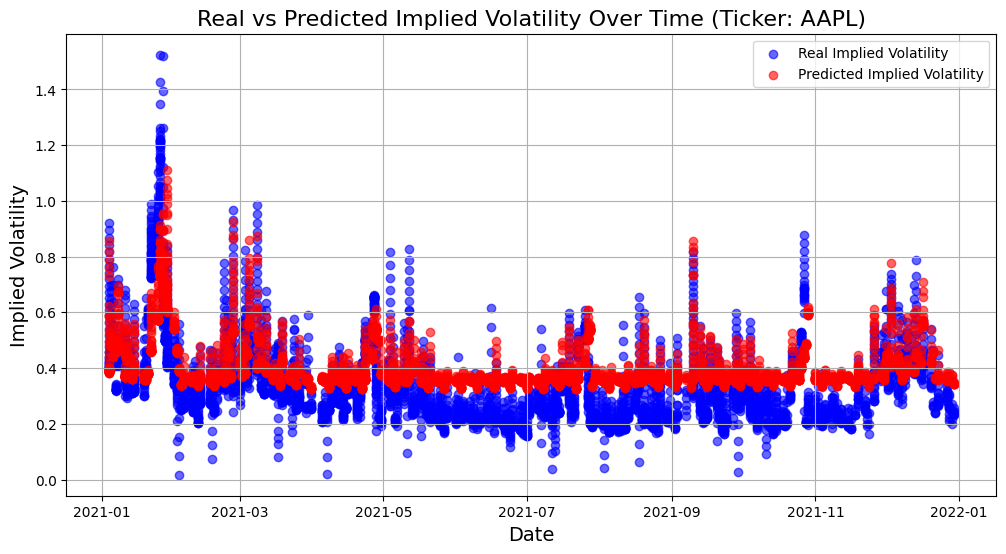

AMZN RMSE: 0.1366717184649714
AMZN R²: 0.7054875644425613


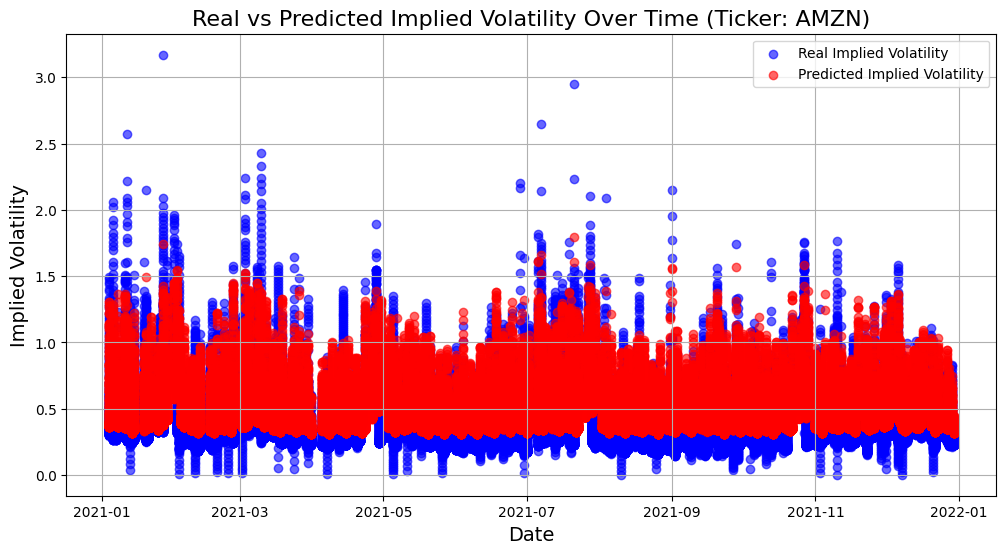

NVDA RMSE: 0.19574428834699018
NVDA R²: 0.6144821964525092


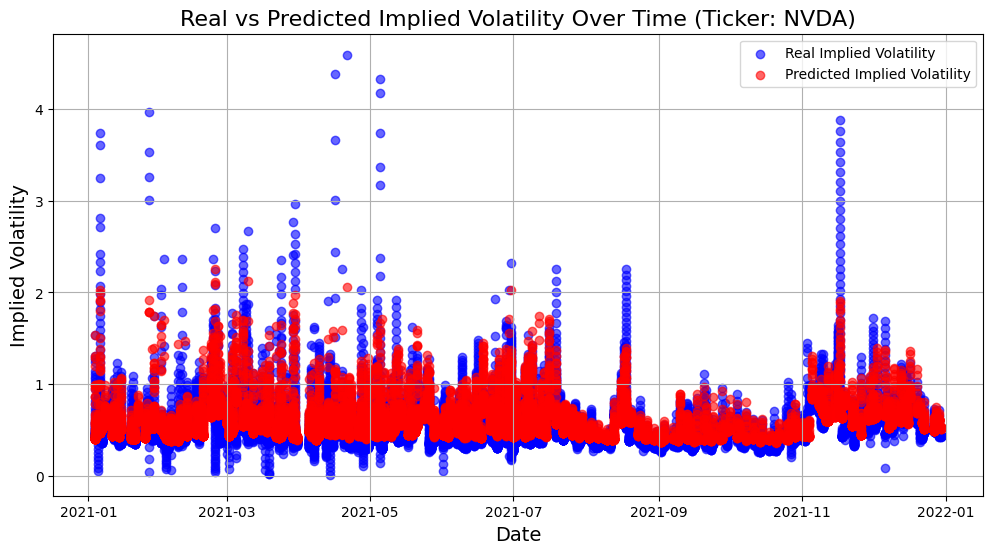

TSLA RMSE: 0.26698342898103744
TSLA R²: 0.6246765006461092


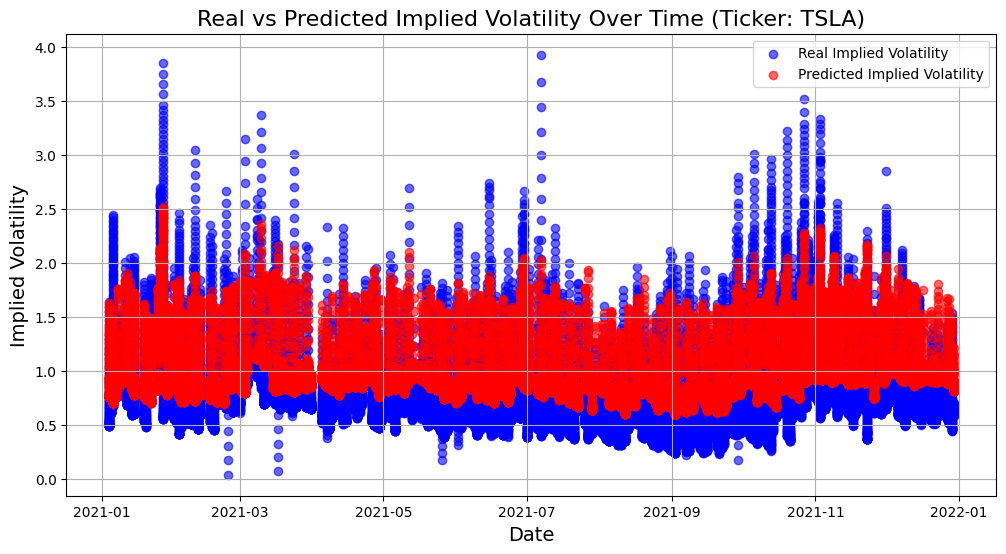

META RMSE: 0.13399473223173838
META R²: 0.5562258129180366


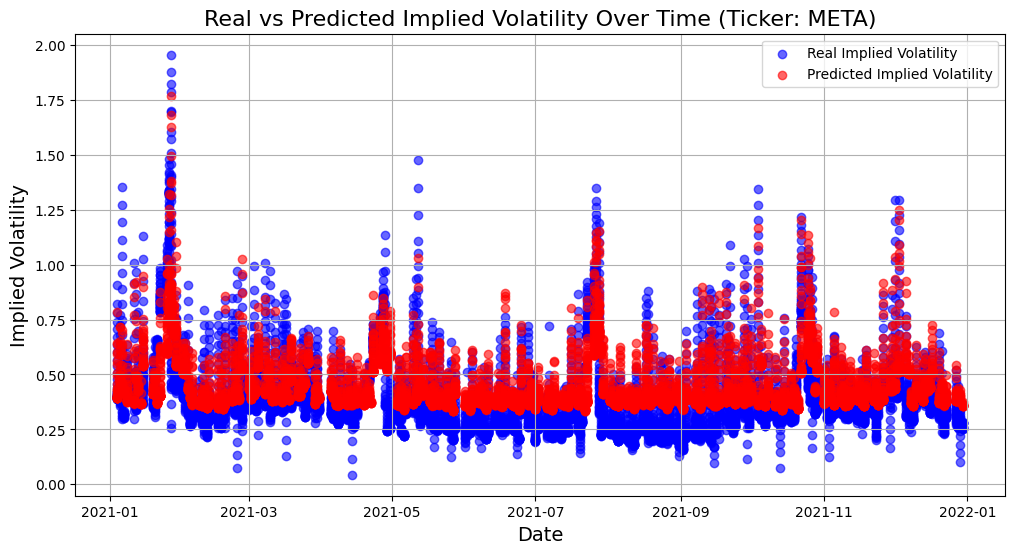

MSFT RMSE: 0.13727160911121036
MSFT R²: 0.03754050233149575


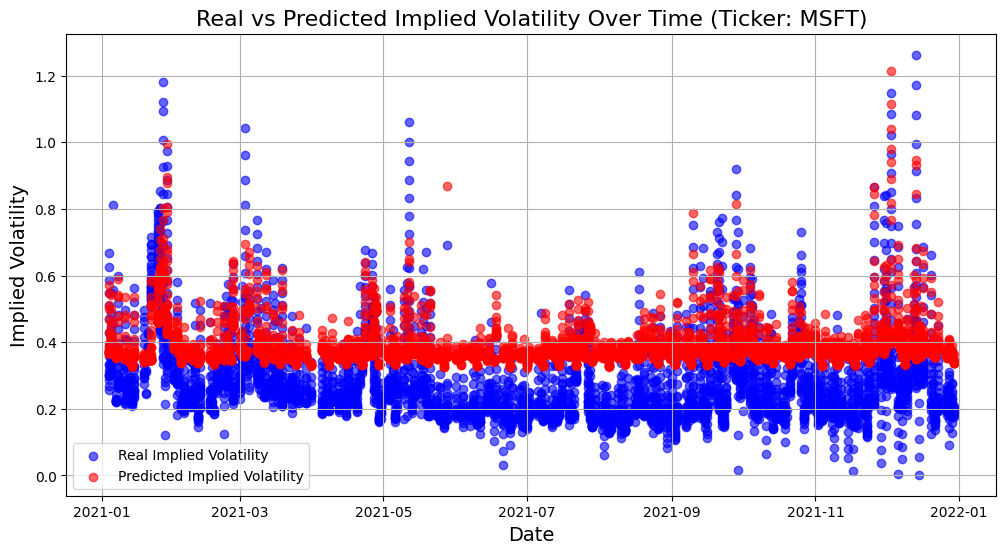

Daily average errors calculated for 250 days.
Newey-West Standard Error (Based on Daily Averages): 0.006823601670932691
Daily average errors and Newey-West statistics saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/rf_all.csv
Overall Weighted RMSE: 0.18179028474591927
Overall Weighted R²: 0.6262113289731922
Overall Combined RMSE: 0.18179028474591927
Overall Combined R²: 0.7389258121666933
Overall Weighted RMSE: 0.18179028474591927
Overall Weighted R²: 0.6262113289731922
Overall Combined RMSE: 0.18179028474591927
Overall Combined R²: 0.7389258121666933
Ticker-Specific Results:
{'Ticker': 'AAPL', 'RMSE': 0.1286889087050941, 'R²': 0.435329075168721}
{'Ticker': 'AMZN', 'RMSE': 0.1366717184649714, 'R²': 0.7054875644425613}
{'Ticker': 'NVDA', 'RMSE': 0.19574428834699018, 'R²': 0.6144821964525092}
{'Ticker': 'TSLA', 'RMSE': 0.26698342898103744, 'R²': 0.6246765006461092}
{'Ticker': 'META', 'RMSE': 0.13399473223173838, 'R²': 0.

In [29]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    X = np.ones(len(errors))  # Constant term for OLS
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return ols_model.bse[0]  # Standard error of the constant term

def predict_test_data_per_ticker(IV, test_data, model, selected_features):
    """
    Predict the target variable for the test set using the trained model,
    calculate RMSE and R² for each ticker, and compute weighted overall metrics.
    Additionally, compute combined overall metrics using all data.

    Parameters:
    IV (str): The name of the independent variable to predict.
    test_data (pd.DataFrame): The test dataset.
    model: The trained model (e.g., RandomForest).
    selected_features (list): The list of features used for modeling.

    Returns:
    dict: Contains RMSE and R² values for each ticker, overall weighted metrics, 
          and combined overall metrics.
    """
    results_list_all = []  # Initialize list to store results
    unique_tickers = test_data['Ticker'].unique()

    # Initialize accumulators for overall RMSE and R²
    total_rmse_weighted_sum = 0
    total_r2_weighted_sum = 0
    total_observations = 0

    # Collect all actual and predicted values for combined metrics
    combined_actual = []
    combined_predicted = []

    for ticker in unique_tickers:
        # Filter the data for the current ticker
        data_ticker = test_data[test_data['Ticker'] == ticker]

        # Separate features and target for the ticker
        y_ticker_actual = data_ticker[IV]
        X_ticker = data_ticker[selected_features]

        # Predict implied volatility using the trained model
        y_ticker_pred = model.predict(X_ticker)

        # Collect predictions and actual values for overall calculation
        combined_actual.extend(y_ticker_actual)
        combined_predicted.extend(y_ticker_pred)

        # Calculate RMSE and R² for the ticker-specific implied volatility prediction
        rmse_ticker = np.sqrt(mean_squared_error(y_ticker_actual, y_ticker_pred))
        r2_ticker = r2_score(y_ticker_actual, y_ticker_pred)

        # Calculate the number of observations for the ticker
        num_observations = len(y_ticker_actual)

        # Weighted summing for overall RMSE and R²
        total_rmse_weighted_sum += num_observations * rmse_ticker**2
        total_r2_weighted_sum += num_observations * r2_ticker
        total_observations += num_observations

        # Save ticker-specific results
        results_list_all.append({
            'Ticker': ticker,
            'RMSE': rmse_ticker,
            'R²': r2_ticker
        })
        print(f'{ticker} RMSE: {rmse_ticker}')
        print(f'{ticker} R²: {r2_ticker}')

        # Plot Real vs Predicted values for the ticker
        plot_real_vs_predicted(data_ticker, y_ticker_actual, y_ticker_pred, f'Ticker: {ticker}')

    # Calculate overall weighted RMSE and R²
    overall_rmse = np.sqrt(total_rmse_weighted_sum / total_observations)
    overall_r2 = total_r2_weighted_sum / total_observations

    # Calculate combined overall RMSE and R² using all data
    combined_actual = np.array(combined_actual)
    combined_predicted = np.array(combined_predicted)

    errors_test = combined_actual - combined_predicted
    test_data['Errors'] = errors_test  # Add errors to the test dataset

    # Group errors by date and calculate daily averages
    if 'date' in test_data.columns:
        daily_avg_errors = test_data.groupby('date')['Errors'].mean()
        print(f"Daily average errors calculated for {len(daily_avg_errors)} days.")
    else:
        raise ValueError("The dataset does not contain a 'date' column.")

    # Calculate Newey-West standard error using daily averages
    nw_std_error_test = newey_west_standard_error(daily_avg_errors.values, lag=1)
    print(f"Newey-West Standard Error (Based on Daily Averages): {nw_std_error_test}")

    # Save the daily errors and Newey-West standard error into a CSV
    file_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/rf_all.csv'

    # Create a DataFrame with daily averaged errors and repeated Newey-West standard error
    dm_test_data = pd.DataFrame({
        'Date': daily_avg_errors.index,
        'Daily Avg Errors': daily_avg_errors.values,
        'Newey-West Std Error': [nw_std_error_test] * len(daily_avg_errors)
    })

    # Save the DataFrame to a CSV
    dm_test_data.to_csv(file_path, index=False)
    print(f"Daily average errors and Newey-West statistics saved to {file_path}")

    overall_combined_rmse = np.sqrt(mean_squared_error(combined_actual, combined_predicted))
    overall_combined_r2 = r2_score(combined_actual, combined_predicted)

    print(f'Overall Weighted RMSE: {overall_rmse}')
    print(f'Overall Weighted R²: {overall_r2}')
    print(f'Overall Combined RMSE: {overall_combined_rmse}')
    print(f'Overall Combined R²: {overall_combined_r2}')

    return {
        'Ticker_Results': results_list_all,
        'Overall_RMSE': overall_rmse,
        'Overall_R²': overall_r2,
        'Overall_Combined_RMSE': overall_combined_rmse,
        'Overall_Combined_R²': overall_combined_r2
    }

def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.

    Parameters:
    test_data (pd.DataFrame): The test dataset containing the date information.
    real_values (np.array or pd.Series): The real implied volatility values.
    predicted_values (np.array or pd.Series): The predicted implied volatility values.
    title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
# Assuming `datat` (test data), `final_rf_model` (trained model), and `totalList` (features) are defined
results = predict_test_data_per_ticker(impl_volatility, datat, final_rf_model, totalList)

# Print overall weighted metrics
print(f"Overall Weighted RMSE: {results['Overall_RMSE']}")
print(f"Overall Weighted R²: {results['Overall_R²']}")
print(f"Overall Combined RMSE: {results['Overall_Combined_RMSE']}")
print(f"Overall Combined R²: {results['Overall_Combined_R²']}")

# Print ticker-specific results
print("Ticker-Specific Results:")
for ticker_result in results['Ticker_Results']:
    print(ticker_result)


In [24]:
# import joblib
# import pandas as pd
# import numpy as np
# from sklearn.metrics import mean_squared_error, r2_score

# # Load the saved model, scaler, and hyperparameters
# final_model = joblib.load('final_rf_model.pkl')

# def predict_test_data_per_ticker(IV, test_data, model, selected_features):
#     """
#     Predict the target variable for the test set using the trained model and scale each ticker's data separately.
#     Parameters:
#     IV (str): The name of the independent variable to predict.
#     test_data (pd.DataFrame): The test dataset.
#     model: The trained ElasticNet model.
#     scaler: The scaler used for feature scaling during training.
#     selected_features (pd.Index): The list of features selected by ElasticNet during training.
#     Returns:
#     list: RMSE and R² values for each ticker in the test set.
#     """
#     results_list_all = []  # Initialize list to store results
#     unique_tickers = test_data['Ticker'].unique()
#     for ticker in unique_tickers:
#         # Filter the data for the current ticker
#         data_ticker = test_data[test_data['Ticker'] == ticker]
#         # Separate features and target for the ticker
#         y_ticker_actual = data_ticker[IV]
#         X_ticker = data_ticker[selected_features]
#         # Transform the test set using the scaler fitted on combined training and validation data
#         # X_ticker_scaled = scaler.transform(X_ticker)
        
#         # Predict implied volatility using the trained model
#         y_ticker_pred = model.predict(X_ticker)

#         # Calculate RMSE and R² for the ticker-specific implied volatility prediction
#         rmse_ticker = np.sqrt(mean_squared_error(y_ticker_actual, y_ticker_pred))
#         r2_ticker = r2_score(y_ticker_actual, y_ticker_pred)
#         # Save results in the list
#         results_list_all.append({
#             'Ticker': ticker,
#             'RMSE': rmse_ticker,
#             'R²': r2_ticker
#         })
#         print(f'{ticker} RMSE: {rmse_ticker}')
#         print(f'{ticker} R²: {r2_ticker}')

#         plot_real_vs_predicted(data_ticker, y_ticker_actual, y_ticker_pred, f'Ticker: {ticker}')

#     return results_list_all

# def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
#     """
#     Plot Real vs Predicted Implied Volatility over time.

#     Parameters:
#     test_data (pd.DataFrame): The test dataset containing the date information.
#     real_values (np.array or pd.Series): The real implied volatility values.
#     predicted_values (np.array or pd.Series): The predicted implied volatility values.
#     title (str): The title for the plot.
#     """
#     plt.figure(figsize=(12, 6))
    
#     # Scatter plot for Real Implied Volatility
#     plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    
#     # Scatter plot for Predicted Implied Volatility
#     plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    
#     # Labels and title
#     plt.xlabel('Date', fontsize=14)
#     plt.ylabel('Implied Volatility', fontsize=14)
#     plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    
#     # Add a legend
#     plt.legend()
    
#     # Grid for better visualization
#     plt.grid(True)
    
#     # Display the plot
#     plt.show()

# # Assuming `data_test_all` and `sorted_features_elnet` are already defined
# results_list_all = predict_test_data_per_ticker('impl_volatility', datat, final_rf_model, totalList)
# # Print best hyperparameters


Baseline R² (OOS): 0.6068
Feature: moneyness, Baseline R²: 0.6068, Perturbed R²: 0.3371, Absolute Change: 0.2697
Feature: T, Baseline R²: 0.6068, Perturbed R²: 0.6088, Absolute Change: 0.0021
Feature: 2Y_bond, Baseline R²: 0.6068, Perturbed R²: 0.6086, Absolute Change: 0.0019
Feature: FF_rate, Baseline R²: 0.6068, Perturbed R²: 0.6056, Absolute Change: 0.0012
Feature: gold_price, Baseline R²: 0.6068, Perturbed R²: 0.6483, Absolute Change: 0.0415
Feature: reces_indi, Baseline R²: 0.6068, Perturbed R²: 0.6044, Absolute Change: 0.0023
Feature: CLOSE_vix, Baseline R²: 0.6068, Perturbed R²: 0.6137, Absolute Change: 0.0070
Feature: hi-lo_vix, Baseline R²: 0.6068, Perturbed R²: 0.6081, Absolute Change: 0.0013
Feature: cp_flag, Baseline R²: 0.6068, Perturbed R²: 0.5996, Absolute Change: 0.0071
Feature: spread_option, Baseline R²: 0.6068, Perturbed R²: 0.6062, Absolute Change: 0.0006
Feature: volume, Baseline R²: 0.6068, Perturbed R²: 0.5457, Absolute Change: 0.0611
Feature: prc_option, Baselin

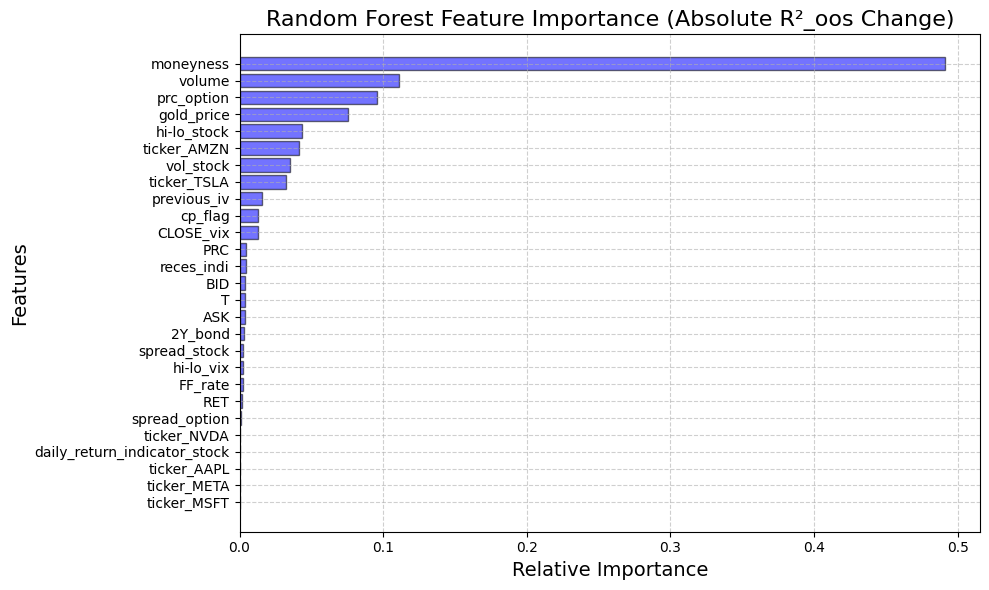

In [19]:
def calculate_feature_importance_r2_rf(data_train, data_test, features, target, model):
    """
    Calculate feature importance for Random Forest based on the absolute change in R²_oos when a feature is set to zero.

    Parameters:
    - data_train: Training dataset
    - data_test: Test dataset
    - features: List of feature names
    - target: Target variable (e.g., implied volatility)
    - model: Trained Random Forest model
    
    Returns:
    - importance_df: DataFrame with feature importance values.
    - baseline_r2: Baseline R²_oos value.
    """
    # Predict on the test data and calculate baseline R²_oos
    X_test = data_test[features]
    y_test = data_test[target]
    y_test_pred = model.predict(X_test)
    baseline_r2 = r2_score(y_test, y_test_pred)
    print(f"Baseline R² (OOS): {baseline_r2:.4f}")

    # Calculate the absolute change in R²_oos for each feature
    r2_changes = []
    for feature in features:
        # Perturb the test data by setting the feature to zero
        X_test_zeroed = X_test.copy()
        X_test_zeroed[feature] = 0

        # Predict and calculate R²_oos
        y_test_pred_zeroed = model.predict(X_test_zeroed)
        r2_zeroed = r2_score(y_test, y_test_pred_zeroed)
        r2_change = abs(baseline_r2 - r2_zeroed)  # Use absolute change
        r2_changes.append(r2_change)

        print(f"Feature: {feature}, Baseline R²: {baseline_r2:.4f}, Perturbed R²: {r2_zeroed:.4f}, Absolute Change: {r2_change:.4f}")

    # Normalize the importance scores
    r2_importance = np.array(r2_changes)
    if r2_importance.sum() > 0:
        r2_importance = r2_importance / r2_importance.sum()  # Normalize to sum to 1
    else:
        r2_importance = np.zeros_like(r2_importance)  # Handle edge case where all changes are zero

    # Create a DataFrame for feature importance
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': r2_importance
    }).sort_values(by='Importance', ascending=False)

    return importance_df, baseline_r2


def plot_feature_importance(importance_df, title="Feature Importance"):
    """
    Plot feature importance as a bar chart.
    
    Parameters:
    - importance_df: DataFrame containing feature names and importance scores.
    - title: Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue', edgecolor='black', alpha=0.55)
    plt.xlabel('Relative Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Example Usage
# Assuming `data` is the training dataset, `datat` is the test dataset,
# `final_rf_model` is the trained Random Forest model, and `totalList` contains feature names.

feature_importance_rf, baseline_r2_rf = calculate_feature_importance_r2_rf(
    data_train=data,
    data_test=datat,
    features=totalList,
    target=impl_volatility,
    model=final_rf_model
)

# Print and visualize the feature importance
print("Feature Importance (Absolute R²_oos Change) for Random Forest:")
print(feature_importance_rf)

plot_feature_importance(feature_importance_rf, title="Random Forest Feature Importance (Absolute R²_oos Change)")


In [31]:
# feature_importance_rf["Importance"].tolist()
feature_importance_rf["Feature"].tolist()

['moneyness',
 'volume',
 'prc_option',
 'gold_price',
 'hi-lo_stock',
 'ticker_AMZN',
 'vol_stock',
 'ticker_TSLA',
 'previous_iv',
 'cp_flag',
 'CLOSE_vix',
 'PRC',
 'reces_indi',
 'BID',
 'T',
 'ASK',
 '2Y_bond',
 'spread_stock',
 'hi-lo_vix',
 'FF_rate',
 'RET',
 'spread_option',
 'ticker_NVDA',
 'daily_return_indicator_stock',
 'ticker_AAPL',
 'ticker_META',
 'ticker_MSFT']